In [1]:
#Would repeat for other cell type

#Paths in /ocean/projects/bio240054p/shared/project/240_predictions_matrix_celltypes/Astro
#/ocean/projects/bio240054p/shared/project/240_predictions_matrix_celltypes/Astro/240_predictions_MatrixStacked.tsv
#/ocean/projects/bio240054p/shared/project/240_predictions_matrix_celltypes/Astro/240_predictions_NamesList.txt

In [2]:
#Install libraries needed downstream

dir.create("~/R/library", recursive = TRUE)  # Create the directory if it doesn't exist
.libPaths("~/R/library")  # Set the library path
install.packages("ape")  # Now install the package
install.packages("BiocManager")
install.packages("phylolm");
BiocManager::install("ggtree")
BiocManager::install("phyloseq")


Warning message in dir.create("~/R/library", recursive = TRUE):
“'/jet/home/shushkov/R/library' already exists”
Installing package into ‘/jet/home/shushkov/R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/jet/home/shushkov/R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/jet/home/shushkov/R/library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ggtree'”
Installation paths not writeable, unable to update packages
  path: /ocean/projects/bio240054p/csestili/env/seuratv5/lib/R/library
  packages:
    FNN, GenomicRanges, MASS, Matrix, askpass, bit, bit64, bitops, commonmark,
    credentials,

In [3]:
library(ape)
library(ggtree)
library(phyloseq)
library(phylolm)

ggtree v3.12.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
for mapping and visualizing associated data on phylogeny using ggtree.
Molecular Biology and Evolution. 2018, 35(12):3041-3043.
doi:10.1093/molbev/msy194

Shuangbin Xu, Lin Li, Xiao Luo, Meijun Chen, Wenli Tang, Li Zhan, Zehan
Dai, Tommy T. Lam, Yi Guan, Guangchuang Yu. Ggtree: A serialized data
object for visualization of a phylogenetic tree and annotation data.
iMeta 2022, 1(4):e56. doi:10.1002/imt2.56 


Attaching package: ‘ggtree’


The following object is masked from ‘package:ape’:


Step 1: Download and Read in Data

In [4]:
#Note: did not use wget, but loaded it into ssh'd Jupyter notebook

astrocytePredictionsPath <- "/ocean/projects/bio240054p/shared/project/240_predictions_matrix_celltypes/Astro/240_predictions_MatrixStacked.tsv"
astrocytePredictions <- read.delim(astrocytePredictionsPath, header = FALSE, sep = "\t")


In [5]:
#head(astrocytePredictions)
dim(astrocytePredictions) #205150 peaks x 242 columns (240 species, 1st column is region)

[1] 205151    242

In [6]:
astrocytePredictionsNamesPath <- "/ocean/projects/bio240054p/shared/project/240_predictions_matrix_celltypes/Astro/240_predictions_NamesList.txt"
astrocytePredictionsNames <- read.delim(astrocytePredictionsNamesPath, header = FALSE, sep = "\t")

In [7]:
head(astrocytePredictionsNames, n=7)
dim(astrocytePredictionsNames)

,V1
,<chr>
1,Acinonyx_jubatus
2,Acomys_cahirinus
3,Ailuropoda_melanoleuca
4,Ailurus_fulgens
5,Allactaga_bullata
6,Alouatta_palliata
7,Ammotragus_lervia


[1] 241   1

In [8]:
# Extract the species names from astrocytePredictionsNames and make them column names
species_names <- astrocytePredictionsNames[[1]]

# Check if the length matches the number of columns (excluding the first)
if (length(species_names) == (ncol(astrocytePredictions) - 1)) {
  
  # Rename the columns in astrocytePredictions (excluding the first column)
  colnames(astrocytePredictions)[2:ncol(astrocytePredictions)] <- species_names
  
  # Print the new column names to verify
  #print(colnames(astrocytePredictions))
} else {
  stop("The number of species names does not match the number of columns in astrocytePredictions.")
}


In [9]:
#head(astrocytePredictions)


In [10]:
# Transpose the astrocytePredictions data frame so species are rows and peaks are columns
astrocytePredictions <- t(astrocytePredictions)

# Convert it back to a data frame
astrocytePredictions <- as.data.frame(astrocytePredictions)

#Fix it so peaks are actually the column names
colnames(astrocytePredictions) <- astrocytePredictions[1, ]
astrocytePredictions <- astrocytePredictions[-1, ]

In [11]:
#head(astrocytePredictions)
#dim(astrocytePredictions)

##### Processing: Remove the extra species from astrocytePredictions and astrocytePredictionsNames compared to Zoonomia data
##### Then, add column to astrocytePredictionsNames that has binary Homeotherm value.

In [12]:
#Load in original data to subset it --> added csv file to home directory of bridges ~___
originalZoonomiaData <- read.csv("Phenotypes_Zoonomia_3.csv", header = TRUE)
sortedZoonomia <- originalZoonomiaData[order(originalZoonomiaData$Name), ]

#Remove rows where Homeotherm value is NA
sortedZoonomia <- sortedZoonomia[!is.na(sortedZoonomia$Homeotherm), ]


In [13]:
head(sortedZoonomia)
dim(sortedZoonomia)

,Name,phylogeny_number,species.binomial,species_synonyms,Taxonomic.lineage,In.Cactus.,Activity.Pattern,Basal.metabolic.rate.BINS,BMR.resids,Mean_brain_mass_g,⋯,Solitary,Social.monogamy,Group.living,Paternal.Care,Number.of.Olfactory.Turbinals,Homeotherm,Torpidator,Deep.Hibernator,Hibernator,Species
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<chr>
2,Acinonyx_jubatus,333,acinonyx_jubatus,NA,Eutheria;Boreoeutheria;Laurasiatheria;Carnivora;Feliformia;Felidae;Acinonychinae;Acinonyx,Yes,DIURNAL,high,0.325,111.00,⋯,1,0,0,0,18,1,0,0,0,Acinonyx_jubatus
4,Ailuropoda_melanoleuca,326,ailuropoda_melanoleuca,NA,Eutheria;Boreoeutheria;Laurasiatheria;Carnivora;Caniformia;Ursidae;Ailuropoda,Yes,CATHEMERAL,NA,NA,205.00,⋯,1,0,0,0,NA,1,0,0,0,Ailuropoda_melanoleuca
5,Ailurus_fulgens,286,ailurus_fulgens,NA,Eutheria;Boreoeutheria;Laurasiatheria;Carnivora;Caniformia;Ailuridae;Ailurus,Yes,DIURNAL,low,-0.646,46.80,⋯,1,0,0,0,NA,1,0,0,0,Ailurus_fulgens
6,Allactaga_bullata,43,allactaga_bullata,NA,Eutheria;Boreoeutheria;Euarchontoglires;Glires;Rodentia;Myomorpha;Dipodoidea;Dipodidae;,Yes,NOCTURNAL,NA,NA,NA,⋯,1,0,0,0,NA,0,0,1,1,Allactaga_bullata
7,Alouatta_palliata,135,alouatta_palliata,NA,Eutheria;Boreoeutheria;Euarchontoglires;Primates;Haplorrhini;Simiiformes;Platyrrhini;Atelidae;,Yes,DIURNAL,NA,NA,50.04,⋯,0,0,1,0,NA,1,0,0,0,Alouatta_palliata
8,Ammotragus_lervia,197,ammotragus_lervia,NA,Eutheria;Boreoeutheria;Laurasiatheria;Artiodactyla;Ruminantia;Pecora;Bovidae;Caprinae;,Yes,DIURNAL,NA,NA,209.00,⋯,1,0,NA,0,NA,1,0,0,0,Ammotragus_lervia


[1] 178 261

In [14]:
# Step 1: Get the species names from sortedZoonomia
zoonomia_species <- sortedZoonomia$Name
#zoonomia_species

astrocytePredictions <- astrocytePredictions[rownames(astrocytePredictions) %in% zoonomia_species, ]
astrocytePredictionsNames <- astrocytePredictionsNames[astrocytePredictionsNames$V1 %in% zoonomia_species, ]

#Need to convert the names back into a df
astrocytePredictionsNames <- data.frame(Species = astrocytePredictionsNames, stringsAsFactors = FALSE)


In [15]:
#head(astrocytePredictions)
dim(astrocytePredictions)

[1]    178 205151

In [16]:
head(astrocytePredictionsNames)
dim(astrocytePredictionsNames)

,Species
,<chr>
1,Acinonyx_jubatus
2,Ailuropoda_melanoleuca
3,Ailurus_fulgens
4,Allactaga_bullata
5,Alouatta_palliata
6,Ammotragus_lervia


[1] 178   1

In [17]:
#Add homeotherm column
astrocytePredictionsNames$Homeotherm <- sortedZoonomia$Homeotherm


In [18]:
head(astrocytePredictionsNames)

,Species,Homeotherm
,<chr>,<int>
1,Acinonyx_jubatus,1
2,Ailuropoda_melanoleuca,1
3,Ailurus_fulgens,1
4,Allactaga_bullata,0
5,Alouatta_palliata,1
6,Ammotragus_lervia,1


In [19]:
dim(astrocytePredictionsNames)

[1] 178   2

2: Calculate difference in open chromatin between/across species of choice

In [20]:
#NOTE: THE TREE SIZE DIFFERENCE COULD CAUSE SOME BUGS BELOW IN PHYLOLM. DO WE NEED TO FURTHER PRUNE DATA TO 163 
# INSTEAD OF 178 SPECIES?

Total number of species in the original tree: 241 
Number of species in the pruned tree: 163 
Species in pheno_df_subset but not in the tree (kept):
 [1] "Balaenoptera_acutorostrata_scammoni"        
 [2] "Bison_bison_bison"                          
 [3] "Cebus_capucinus_imitator"                   
 [4] "Colobus_angolensis_palliatus"               
 [5] "Dicerorhinus_sumatrensis_sumatrensis"       
 [6] "Equus_asinus_asinus"                        
 [7] "Gorilla_gorilla_gorilla"                    
 [8] "Marmota_marmota_marmota"                    
 [9] "Neophocaena_asiaeorientalis_asiaeorientalis"
[10] "Oryctolagus_cuniculus_cuniculus"            
[11] "Ovis_canadensis_canadensis"                 
[12] "Panthera_tigris_altaica"                    
[13] "Perognathus_longimembris_pacificus"         
[14] "Peromyscus_maniculatus_bairdii"             
[15] "Saimiri_boliviensis_boliviensis"            


[1] "character"

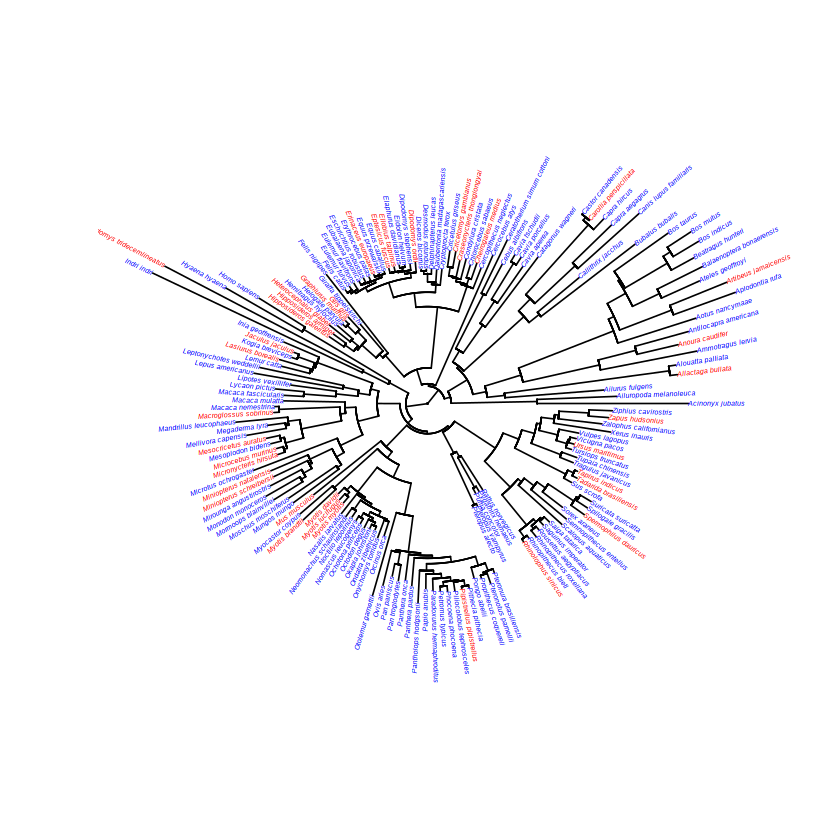

In [21]:
# Tree info - added tree file to ~ path


# Read the tree
tree <- read.tree("Zoonomia_ChrX_lessGC40_241species_30Consensus.tree")
total_species <- length(tree$tip.label)
cat("Total number of species in the original tree:", total_species, "\n")

# Read the phenotypes data
pheno_df <- read.csv("Phenotypes_Zoonomia_3.csv")

# Create a subset of pheno_df to include only species with Homeotherm values
pheno_df_subset <- pheno_df[!is.na(pheno_df$Homeotherm), c("Homeotherm", "Species")]
rownames(pheno_df_subset) <- pheno_df_subset$Species
pheno_df_subset$Homeotherm <- factor(pheno_df_subset$Homeotherm)

# Trim whitespace from species names
tree$tip.label <- trimws(tree$tip.label)
pheno_df_subset$Species <- trimws(pheno_df_subset$Species)

# Identify species in pheno_df_subset that are not in the tree
species_not_in_tree <- setdiff(pheno_df_subset$Species, tree$tip.label)

# Remove species not present in the tree
remove_species <- setdiff(tree$tip.label, pheno_df_subset$Species)
pruned_tree <- drop.tip(tree, remove_species)
pruned_tree$tip.label <- sort(pruned_tree$tip.label)


# Print the number of species in the pruned tree
num_species_pruned <- length(pruned_tree$tip.label)
cat("Number of species in the pruned tree:", num_species_pruned, "\n")

# Prepare tip colors based on Homeotherm factor
useTipColorsV <- c("red", "blue")
tipColorsV <- useTipColorsV[pheno_df_subset[pruned_tree$tip.label, "Homeotherm"]]

# Plot the pruned tree
plot(pruned_tree, type = "fan", cex = 0.3, tip.color = tipColorsV)

# Print species not included in the tree
cat("Species in pheno_df_subset but not in the tree (kept):\n")
print(species_not_in_tree)
class(species_not_in_tree)







In [22]:
vector_to_remove <- c('Balaenoptera_acutorostrata', 'Bison_bison', 'Cebus_capucinus', 'Colobus_angolensis', 'Dicerorhinus_sumatrensis', 'Equus_asinus',
                     'Gorilla_gorilla', 'Marmota_marmota', 'Neophocaena_asiaeorientalis', 'Oryctolagus_cuniculus', 'Ovis_canadensis', 'Panthera_tigris',
                     'Perognathus_longimembris', 'Peromyscus_maniculatus', 'Saimiri_boliviensis')

#astrocytePredictions
#astrocytePredictionsNames


astrocytePredictionsNames = astrocytePredictionsNames[-(which(astrocytePredictionsNames$Species %in% vector_to_remove)),]
#astrocytePredictionsNames
dim(astrocytePredictionsNames)

[1] 163   2

In [23]:
astrocytePredictions = astrocytePredictions[-(which(rownames(astrocytePredictions) %in% vector_to_remove)),]
dim(astrocytePredictions)
#head(astrocytePredictions)

[1]    163 205151

In [24]:
# testPeaksV <- rownames(peakPredM);

# #loopPeaksV <- testPeaksV[1:1000];
# loopPeaksV <- testPeaksV;

# peakPhyloResultsF <- data.frame(peakId = loopPeaksV, pvalue=rep(NA,length(loopPeaksV)),correlation=rep(NA,length(loopPeaksV)),adjCorrelation=rep(NA,length(loopPeaksV)));
# rownames(peakPhyloResultsF) <- peakPhyloResultsF$peakId

# options(warn=-1)

# for(curPeak in loopPeaksV) {
#   speciesDetailedInfoTmpF <- speciesDetailedInfoF;
#   speciesDetailedInfoTmpF$curPeak <- peakPredM[curPeak,];

#   curLmFit = phylolm(curPeak~longevity,data=speciesDetailedInfoTmpF,phy=zoonomiaTree,model="BM");
#   curLmFitSum <- summary(curLmFit)
#   peakPhyloResultsF[curPeak,"pvalue"] <- curLmFitSum$coefficients["longevity","p.value"]
#   peakPhyloResultsF[curPeak,"correlation"] <- curLmFitSum$r.squared
#   peakPhyloResultsF[curPeak,"adjCorrelation"] <- curLmFitSum$adj.r.squared
# }

# options(warn=0)

# peakPhyloResults2F <- peakPhyloResultsF[order(peakPhyloResultsF$pvalue,decreasing=F),]
# peakPhyloResults2F[1:10,]

In [25]:
#length(pruned_tree$tip.label)

In [26]:
#pruned_tree$tip.label

In [27]:
# #pruned_tree$tip.label
# #astrocytePredictionsNames$Species

# species_only_in_tree <- setdiff(pruned_tree$tip.label, astrocytePredictionsNames$Species)

# # Find species in astrocytePredictionsNames$Species but not in pruned_tree$tip.label
# species_only_in_predictions <- setdiff(astrocytePredictionsNames$Species, pruned_tree$tip.label)

# # Print the results
# species_only_in_tree
# species_only_in_predictions

In [28]:
# head(astrocytePredictions)

In [125]:
#dim(astrocytePredictions)

[1]    163 205151

In [29]:
testPeaksV <- colnames(astrocytePredictions)

loopPeaksV <- testPeaksV[1:50]
#loopPeaksV <- testPeaksV

peakPhyloResultsF <- data.frame(peakId = loopPeaksV, pvalue=rep(NA,length(loopPeaksV)),correlation=rep(NA,length(loopPeaksV)),adjCorrelation=rep(NA,length(loopPeaksV)))
rownames(peakPhyloResultsF) <- peakPhyloResultsF$peakId

options(warn=-1)

for(curPeak in loopPeaksV) {
  speciesDetailedInfoTmpF <- astrocytePredictionsNames

  # Align speciesDetailedInfoTmpF with pruned_tree$tip.label
  matching_order <- match(pruned_tree$tip.label, speciesDetailedInfoTmpF$Species)

  # Reorder speciesDetailedInfoTmpF and astrocytePredictions according to the tree tip labels
  speciesDetailedInfoTmpF <- speciesDetailedInfoTmpF[matching_order, ]
  astrocytePredictions <- astrocytePredictions[matching_order, ]

  # Assign the current peak data
  speciesDetailedInfoTmpF$curPeak <- astrocytePredictions[, curPeak]
  speciesDetailedInfoTmpF$curPeak <- as.numeric(speciesDetailedInfoTmpF$curPeak)

  rownames(speciesDetailedInfoTmpF) <- NULL
  rownames(speciesDetailedInfoTmpF) = speciesDetailedInfoTmpF$Species
    
  # Perform the phylogenetic regression
  #print('started')
  #print(speciesDetailedInfoTmpF)
  curLmFit = phylolm(curPeak ~ Homeotherm, data=speciesDetailedInfoTmpF, phy=pruned_tree, model="BM")
  #print('here')
  curLmFitSum <- summary(curLmFit)

  # Store the results
  peakPhyloResultsF[curPeak, "pvalue"] <- curLmFitSum$coefficients["Homeotherm", "p.value"]
  peakPhyloResultsF[curPeak, "correlation"] <- curLmFitSum$r.squared
  peakPhyloResultsF[curPeak, "adjCorrelation"] <- curLmFitSum$adj.r.squared
}

options(warn=0)

peakPhyloResults2F <- peakPhyloResultsF[order(peakPhyloResultsF$pvalue, decreasing=F),]
peakPhyloResults2F[1:5,]


,peakId,pvalue,correlation,adjCorrelation
,<chr>,<dbl>,<dbl>,<dbl>
hg38:chr4:85338100-85338601,hg38:chr4:85338100-85338601,1.474269e-10,0.2257216,0.2209125
hg38:chr1:39954861-39955362,hg38:chr1:39954861-39955362,7.243049e-10,0.2105811,0.2056779
hg38:chr4:82797644-82798145,hg38:chr4:82797644-82798145,1.909571e-09,0.2012303,0.1962690
hg38:chr4:84917046-84917547,hg38:chr4:84917046-84917547,8.655515e-09,0.1864561,0.1814030
hg38:chr4:82717928-82718429,hg38:chr4:82717928-82718429,9.169073e-09,0.1858879,0.1808313


In [30]:
dim(peakPhyloResults2F)

[1] 50  4

In [31]:
write.csv(peakPhyloResults2F, file = "~/peakPhyloResults2F.csv", row.names = FALSE)


In [32]:
class(peakPhyloResults2F)

[1] "data.frame"

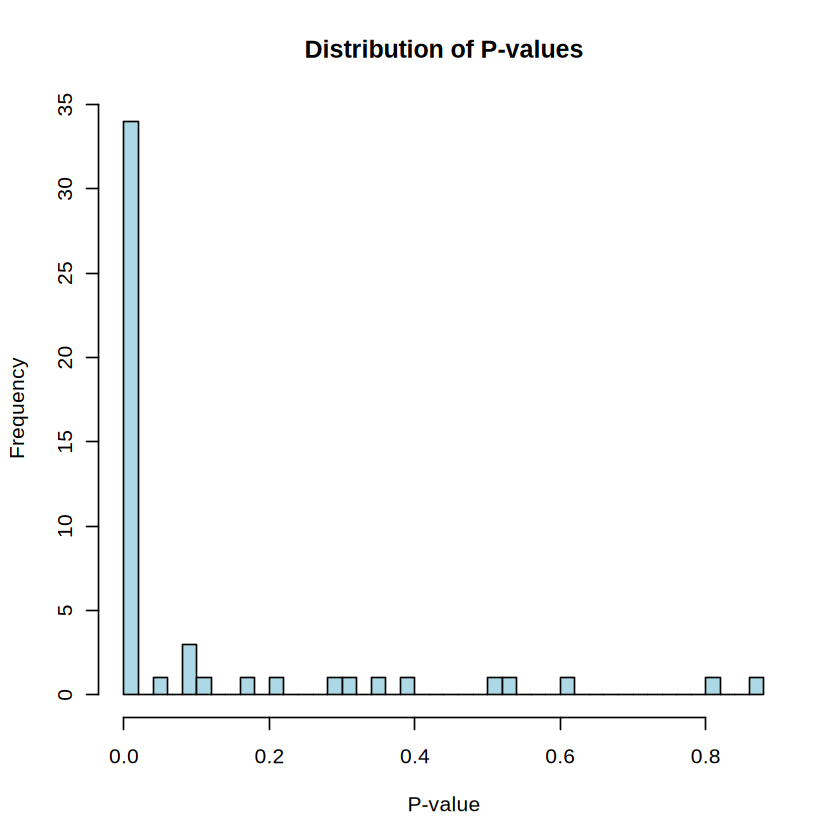

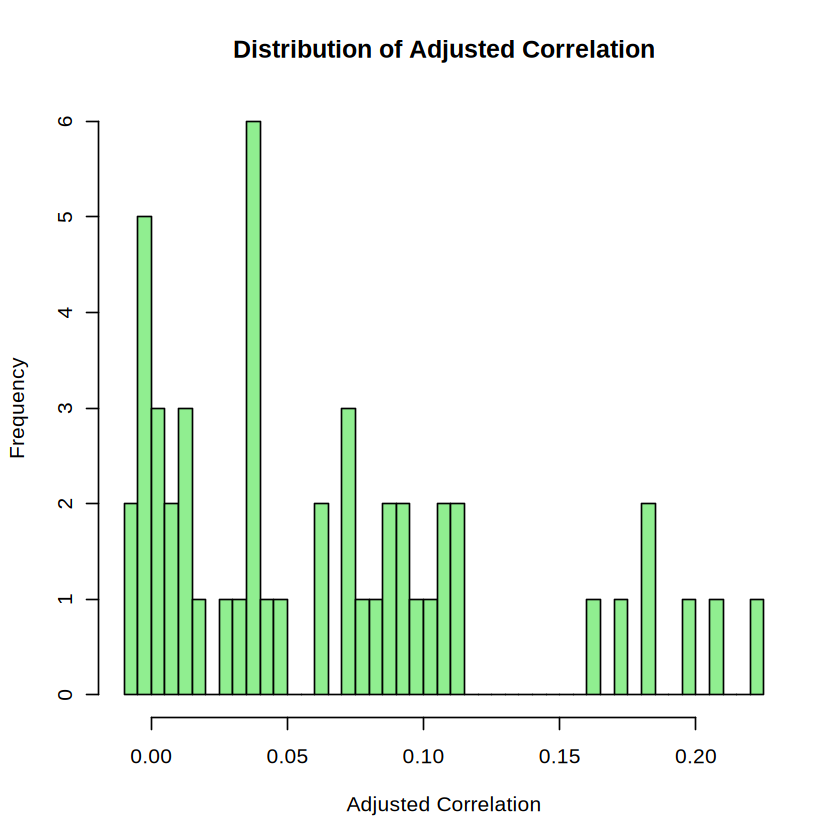

In [33]:
#Plot histogram of distribution of values for both measures (p-val and magnitude/direction)

# Assuming your dataframe is named 'peakPhyloResults2F'
# P-value Histogram
hist(peakPhyloResults2F$pvalue, breaks=50, main="Distribution of P-values", xlab="P-value", col="lightblue")

# Adjusted Correlation Histogram
hist(peakPhyloResults2F$adjCorrelation, breaks=50, main="Distribution of Adjusted Correlation", xlab="Adjusted Correlation", col="lightgreen")


In [34]:
#Performing p-value correction for multiple hypotheses
#Note: do we have adjCorrelation < 0 anywhere? YES

# Apply FDR correction - Bonferroni
peakPhyloResults2F$adjusted_pvalue <- p.adjust(peakPhyloResults2F$pvalue, method = "BH")

# Count significant regions at adjusted p-value <= 0.1
sig_pos <- sum(peakPhyloResults2F$adjusted_pvalue <= 0.1 & peakPhyloResults2F$adjCorrelation > 0)
sig_neg <- sum(peakPhyloResults2F$adjusted_pvalue <= 0.1 & peakPhyloResults2F$adjCorrelation < 0)

cat("Significantly positively associated regions:", sig_pos, "\n")
cat("Significantly negatively associated regions:", sig_neg, "\n")


Significantly positively associated regions: 35 
Significantly negatively associated regions: 0 


#### 3: Most Positive and Negative Assosicated Peak with Trait (p-val)

In [35]:
# Filter the rows where adjCorrelation is negative
negative_adj_corr <- peakPhyloResults2F[peakPhyloResults2F$adjCorrelation < 0, ]

# Print the p-values for those rows
print(negative_adj_corr$pvalue)


[1] 0.3548132 0.3842776 0.5170716 0.5392095 0.6005693 0.8028375 0.8745674


In [37]:
# Filter the rows where adjCorrelation is positive and negative
positive_adj_corr <- peakPhyloResults2F[peakPhyloResults2F$adjCorrelation > 0, ]
negative_adj_corr <- peakPhyloResults2F[peakPhyloResults2F$adjCorrelation < 0, ]

# Find the row with the lowest p-value among the positive adjCorrelation
most_pos_assoc_peak <- positive_adj_corr[which.min(positive_adj_corr$pvalue), ]

# Find the row with the lowest p-value among the negative adjCorrelation
most_neg_assoc_peak <- negative_adj_corr[which.min(negative_adj_corr$pvalue), ]

# Print the results
print("Most positively associated peak (lowest p-value for positive adjCorrelation):")
print(most_pos_assoc_peak)

print("Most negatively associated peak (lowest p-value for negative adjCorrelation):")
print(most_neg_assoc_peak)


[1] "Most positively associated peak (lowest p-value for positive adjCorrelation):"
                                                 peakId       pvalue
hg38:chr4:85338100-85338601 hg38:chr4:85338100-85338601 1.474269e-10
                            correlation adjCorrelation adjusted_pvalue
hg38:chr4:85338100-85338601   0.2257216      0.2209125    7.371344e-09
[1] "Most negatively associated peak (lowest p-value for negative adjCorrelation):"
                                                 peakId    pvalue correlation
hg38:chr4:83012761-83013262 hg38:chr4:83012761-83013262 0.3548132 0.005320146
                            adjCorrelation adjusted_pvalue
hg38:chr4:83012761-83013262  -0.0008579898       0.4031968


####4: Top 200 Positive and Negative Peaks for GREAT

In [32]:
# Sort by p-value and filter for positive and negative correlations
top_200_positive <- peakPhyloResults2F[peakPhyloResults2F$adjCorrelation > 0, ][order(peakPhyloResults2F$pvalue[peakPhyloResults2F$adjCorrelation > 0]), ][1:10, ] #[1:200,]
top_200_negative <- peakPhyloResults2F[peakPhyloResults2F$adjCorrelation < 0, ][order(peakPhyloResults2F$pvalue[peakPhyloResults2F$adjCorrelation < 0]), ][1:10, ] #[1:200,]

# Preview the result
print(head(top_200_positive))
print(head(top_200_negative))


                                                 peakId       pvalue
hg38:chr4:85338100-85338601 hg38:chr4:85338100-85338601 1.474269e-10
hg38:chr1:39954861-39955362 hg38:chr1:39954861-39955362 7.243049e-10
hg38:chr4:82797644-82798145 hg38:chr4:82797644-82798145 1.909571e-09
hg38:chr4:84917046-84917547 hg38:chr4:84917046-84917547 8.655515e-09
hg38:chr4:82717928-82718429 hg38:chr4:82717928-82718429 9.169073e-09
hg38:chr4:86359814-86360315 hg38:chr4:86359814-86360315 2.020059e-08
                            correlation adjCorrelation adjusted_pvalue
hg38:chr4:85338100-85338601   0.2257216      0.2209125    7.371344e-09
hg38:chr1:39954861-39955362   0.2105811      0.2056779    1.810762e-08
hg38:chr4:82797644-82798145   0.2012303      0.1962690    3.182618e-08
hg38:chr4:84917046-84917547   0.1864561      0.1814030    9.169073e-08
hg38:chr4:82717928-82718429   0.1858879      0.1808313    9.169073e-08
hg38:chr4:86359814-86360315   0.1780668      0.1729616    1.683382e-07
                    

In [33]:
# Function to split peakId into chromosome, start, stop
extract_bed_info <- function(peakId) {
  split_info <- strsplit(peakId, ":|-")[[1]] # Split by : and -
  chr <- split_info[2]   # Chromosome
  start <- split_info[3] # Start position
  stop <- split_info[4]  # End position
  return(c(chr, start, stop))
}

# Apply this function to both positive and negative data
top_200_positive_bed <- t(apply(top_200_positive, 1, function(x) extract_bed_info(x['peakId'])))
top_200_negative_bed <- t(apply(top_200_negative, 1, function(x) extract_bed_info(x['peakId'])))


In [34]:
# # Add peakId to the BED information
# top_200_positive_bed <- data.frame(top_200_positive_bed, peakId = top_200_positive$peakId)
# top_200_negative_bed <- data.frame(top_200_negative_bed, peakId = top_200_negative$peakId)

# # Rename the columns to match BED format
# colnames(top_200_positive_bed) <- c("chr", "start", "stop", "peakId")
# colnames(top_200_negative_bed) <- c("chr", "start", "stop", "peakId")

# # Write to BED files
# write.table(top_200_positive_bed, file = "top_200_positive_peaks.bed", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)
# write.table(top_200_negative_bed, file = "top_200_negative_peaks.bed", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)


In [35]:
# # Extract all peaks
# all_peaks_bed <- t(apply(df, 1, function(x) extract_bed_info(x['peakId'])))
# all_peaks_bed <- data.frame(all_peaks_bed, peakId = df$peakId)

# # Rename columns for BED format
# colnames(all_peaks_bed) <- c("chr", "start", "stop", "peakId")

# # Write to a BED file for all peaks
# write.table(all_peaks_bed, file = "all_peaks_cell_type.bed", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)
